In [81]:
import numpy as np
import operator
from enum import Enum
import matplotlib.pyplot as plt
from itertools import cycle
from tqdm import tqdm
import random

In [82]:
# zmienne parametry ustawiane według potrzeb

N = 20 # liczba wszystkich agentów
N_p = int(0.2*N)  # liczba autorów, którzy opublikowali artykuł - 20% wszystkich agentów

n_sym = 5 # liczba przeprowadzonych symulacji
n_krok = 20 # liczba przeprowadzonych kroków w każdej symulacji
time_steps = 10 # liczba ostatnich kroków (po ustaleniu się układu), po których uśredniano wyniki 

v = 1  # współczynnik przypisywania jakości artykułom na podstawie zasobów
Q_sigma = 0.03  # odchylenie standardowe przy tworzeniu artykułu - badano również wartość 0
a = 0.005  # parametr skalujący zasoby po udanej publikacji
R_0 = 3  # liczba początkowa zasobów przypisywana każdemu agentowi
R_plus = 1  # liczba zasobów dodawanych po każdym kroku każdemu agentowi

In [83]:
'''
    Klasa zachowań recenzentów: rzeteleny i niewiarygodny
'''
class referee_behaviour(Enum):
    random = 1
    normal = 2

In [84]:
'''
    Klasa agenta, która zawiera id, zasoby, typ zachowania jako recenzent, 
    listę opublikowanych i zrecenzowanych prac w każdej symulacji.  Posiada również dwie funkcje,
    dodające odpowiednie artykuły do list z napisanymi i zrecenzowanymi pracami.
'''
class Scientist:
    def __init__(self, id, R, type_ref):
        self.id = id  # id agenta
        self.R = R  # zasoby agenta
        self.type_ref = type_ref  # zachowanie w roli recenzenta
        self.pubs = []  # lista napisanych prac
        self.est = []  # lista zrecenzowanych prac

    def add_pub(self,p):  # dodanie pracy napisanej
        self.pubs.append(p)

    def add_est(self,p):  # dodanie pracy zrecenzowanej
        self.est.append(p)

In [85]:
'''
    Klasa artykułu zawierająca jego autora, jego jakość, recenzenta, jakość estymowaną, 
    status (opublikowana lub nieopublikowana), krok symulacji, w którym została napisana 
    oraz zachowanie recenzenta
'''
class Publication:
    def __init__(self, auth, Q, ref, Q_est, status, i, ref_beh):
        self.auth = auth  # autor artykułu
        self.Q = Q  # jakosc artykułu
        self.ref = ref  # recenzent artykułu
        self.Q_est = Q_est  # estymowana jakosc artykułu
        self.status = status  # True - opublikowana, False - nieopublikowana
        self.i = i  # numer kroku symulacji 
        self.ref_beh = ref_beh  # zachowanie recenzenta

In [86]:
'''
    Funkcja przypisująca jakość artykułowi na podstawie zasobów autora
'''
def set_Q(author): # ustawienie jakosci publikacji
    Q_mean = v*author.R/(v*author.R+1)  #średnia oczekiwana jakość artykułu
    while True:
        Q = np.random.normal(Q_mean, Q_sigma)  # jakość losowana z rozkładu normalnego o zadanym odchyleniu standardowym
        if Q<=1 and Q>=0:  # jakość ograniczona do przedziału [0,1]
            break
        else:
            continue
    return Q

In [87]:
'''
    Funkcja estymująca jakość artykułu przez recenzenta 
'''
def set_Q_est(referee,publication): 
    if (referee.type_ref == referee_behaviour.normal):
        Q_est = publication.Q   # recenzent rzetelny dokładnie estymuje jakość artykułu
    elif (referee.type_ref == referee_behaviour.random):
        Q_est = np.random.uniform()  # recenzent niewiarygodny losuje liczbę z rozkładu normalnego [0,1]
    return Q_est

In [88]:
'''
    Funkcja aktualizująca zasoby po każdym kroku każdemu agnetowi.
'''
def update_R(scientist, publication,u): 
    if publication.status == True:
        m = 1-scientist.R*a/(a*scientist.R+1)  # współczynnik skalujący zasoby po udanej publikacji
        scientist.R = scientist.R + scientist.R*m # aktualizacja zasobów po udanej publikacji
    else:
        scientist.R = u*scientist.R   # aktualizacja zasobów po nieudanej publikacji
    scientist.R += R_plus  # dodanie zasobow po kazdym kroku każdemu agentowi

In [89]:
'''
    Funkcja tworząca agentów przypisująca każdemu id, początkowe zasoby oraz zachowanie w roli recenzenta
    w zależności od liczby wprowadzonych niewiarygodnych recenzentów.
'''
def create_scientist(n_random): 
    list_of_scientists = np.zeros(N,dtype=object)
    list_of_behaviour = [referee_behaviour.random if i<n_random else referee_behaviour.normal if i>=n_random else None for i in range(N)]
    
    for i in range(N):
        s = Scientist(i,R_0,None)
        s.type_ref = list_of_behaviour[i]
        list_of_scientists[i] = s
    return list_of_scientists

In [90]:
'''
    Klasa symulacji z funkcjami do wyznaczania parametrów modelu.
'''
class Simulation:

    #  funkcja inicjalizująca liczbę agentów, liczbę prac, które mogą być opublikowane oraz liczbę niewiarygodnych recenzentów
    def __init__(self,N_a,N_p,n_random):
        self.N_A = N_a
        self.N_p = N_p
        self.n_random = n_random

        self.list_of_scientists = create_scientist(self.n_random)  # stworzenie agentów

        self.evaluation_bias = np.zeros(n_krok)
        self.gini_array = np.zeros(n_krok)
        self.dif_R_array = np.zeros(n_krok)
 
    #  funkcja uruchamiana w każdym kroku
    def function(self,t,u):  # t - krok symulacji, u - parametr skalujący zasoby po nieudanej publikacji

        publications = np.zeros(N,dtype=object)
        published = np.zeros(N_p,dtype=object)
        should_be_published = np.zeros(N_p,dtype=object)

        # mieszanie agentów w celu losowego podziału na autorów i recenzentów
        # oraz przypisywanie agentowi następnego agenta z listy
        cycle_N = cycle(list(range(N)))
        next(cycle_N)
        random.shuffle(self.list_of_scientists)
        
        # stworzenie artykułów, przypisanie im jakości, recenzenta oraz aktualizacja prac agentom
        for i in range(N):  
            p = Publication(self.list_of_scientists[i], set_Q(self.list_of_scientists[i]), None,None,False,t,None)
            publications[i] = p
            ref = next(cycle_N)
            p.ref = self.list_of_scientists[ref]
            p.ref_beh = self.list_of_scientists[ref].type_ref
            p.Q_est = set_Q_est(self.list_of_scientists[ref],p)
            self.list_of_scientists[i].add_pub(p)  # dodanie pracy do autora
            self.list_of_scientists[ref].add_est(p)  # dodanie pracy do recenzenta
          
            
        # Sortowanie publikacji malejąco według jakości artykułu oraz według estymowanej jakości
        sorted_pub_Q_est = sorted(publications,key=operator.attrgetter('Q_est'), reverse = True) #opubliowane
        sorted_pub_Q = sorted(publications,key=operator.attrgetter('Q'), reverse = True) #powinny byc opublikowane
        
        
        # Lista opublikowanych i nieopublikowanych artykułów
        for i in range(N_p):
            sorted_pub_Q_est[i].status = True  # ustawienie statusu pracy jako opublikowana
            published[i] = sorted_pub_Q_est[i]  # prace opublikowane
            should_be_published[i] = sorted_pub_Q[i]  # prace, które powinny być opublikowane
        
        # wyznaczenie stronniczosci oceny - evaluation bias
        EB = len(set(published) - set(should_be_published))
        self.evaluation_bias[t-1] = EB/len(published)

        # aktualizacja zasobów
        for x,y in zip(self.list_of_scientists, publications):
            update_R(x,y,u)  # update zasobów
                    
        # wyznaczenie wskaźnika Giniego oraz różnicy między zasobami agenta a średnią zasobów         
        self.Gini_and_diff_resources(t-1,publications,self.gini_array,self.dif_R_array)
        
        
    #  funkcja wyznaczająca wskaźnik Giniego oraz różnicę między zasobami agenta a średnią zasobów        
    def Gini_and_diff_resources(self,t,publications,gini_array,dif_R_array):   
        diff = 0
        dif = 0
        resources = 0
        for i in publications:
            resources += i.auth.R
            for j in publications:
                diff += np.abs(i.auth.R-j.auth.R)  
        mean_R = resources/len(publications)  # wyznaczenie średniej zasobów
        gini = diff/(2*mean_R*len(publications)**2)  # wzór na wskaźnik Giniego
        gini_array[t] = gini
        
        for k in publications:
            dif += np.abs(k.auth.R-mean_R)
        dif_mean_R = dif/mean_R/len(publications)  # wzór na różnicę zasobów
        dif_R_array[t]=dif_mean_R
        
    # funkcja wyznaczająca liczbę autorów, który nieopublikowali żadnego artykułu    
    def unpub_authors(self):
        number_of_unpub_authors = 0
        for i in self.list_of_scientists:
            l=0
            statuses = np.zeros(time_steps)
            for j in i.pubs[-time_steps:]:
                statuses[l] = j.status
                l+=1
            if any(statuses) == False:
                number_of_unpub_authors +=1
        return number_of_unpub_authors
    
        
     #  wyznaczanie średnich wartości parametrów po jednej symulacji
    def mean_params_in_step(self,n,percentage_unpublicated_authors_array,evaluation_bias_array,gini_array,dif_R_array):

        EB_mean = np.mean(self.evaluation_bias[-time_steps:])  
        evaluation_bias_array[n]=EB_mean 
        
        number_of_unpub_authors = self.unpub_authors()
        percent_unpublished_authors = number_of_unpub_authors/N*100
        percentage_unpublicated_authors_array[n]=percent_unpublished_authors
        
        gini_mean = np.mean(self.gini_array[-time_steps:])
        gini_array[n]=gini_mean
        
        dif_R_mean = np.mean(self.dif_R_array[-time_steps:])
        dif_R_array[n]=dif_R_mean
    
    # funkcja wyznaczająca zasoby agentów w jednym kroku    
    def resources(self,n,resources):
        if n==0:
            for i in self.list_of_scientists:
                resources[np.where(self.list_of_scientists==i)] = i.R
    

In [91]:
# funkcja uśredniająca wartości parametrów po wszyskich symulacjach
def mean_many_simulations(unpub_auth,bias, gini,dif_R):
    return np.mean(unpub_auth), np.mean(bias), np.mean(gini), np.mean(dif_R)

In [92]:
randoms = np.arange(0,100,5)

# funkcja przeprowadzająca symulację
def run_simulation(i,u):
    
    bias = np.zeros(n_sym)
    gini = np.zeros(n_sym)
    unpub_auth = np.zeros(n_sym)
    dif_R = np.zeros(n_sym)
        
    for ss in range(n_sym):
        s = Simulation(N,N_p,i)        

        for j in range(n_krok): 
            s.function(j+1,u) 
        s.mean_params_in_step(ss,unpub_auth,bias,gini,dif_R)
        
    unpub_auth_m,bias_m, gini_m, dif_R_m = mean_many_simulations(unpub_auth,bias,gini,dif_R)

    globals()[f"array_ev_bias{u}"][np.where(randoms==i)] = bias_m
    globals()[f"array_gini{u}"][np.where(randoms==i)] =  gini_m
    globals()[f"array_unpub_auth{u}"][np.where(randoms==i)] = unpub_auth_m
    globals()[f"array_diff_R{u}"][np.where(randoms==i)] = dif_R_m

    

In [93]:
U = [0, 0.25,0.5, 0.75, 0.9, 1]  # wartości parametru skalującego zasoby po nieudanej publikacji

for u in U:
    globals()[f"array_ev_bias{u}"] = np.zeros(len(randoms))
    globals()[f"array_gini{u}"] = np.zeros(len(randoms))
    globals()[f"array_unpub_auth{u}"] = np.zeros(len(randoms))
    globals()[f"array_diff_R{u}"] = np.zeros(len(randoms))
    
# uruchomienie symulacji dla różnej liczby zachowań niewiarygodnych oraz różnych wartości parametru u
for u in U:
   for i in tqdm(randoms):
       run_simulation(i,u)
  


100%|██████████| 20/20 [00:03<00:00,  6.20it/s]


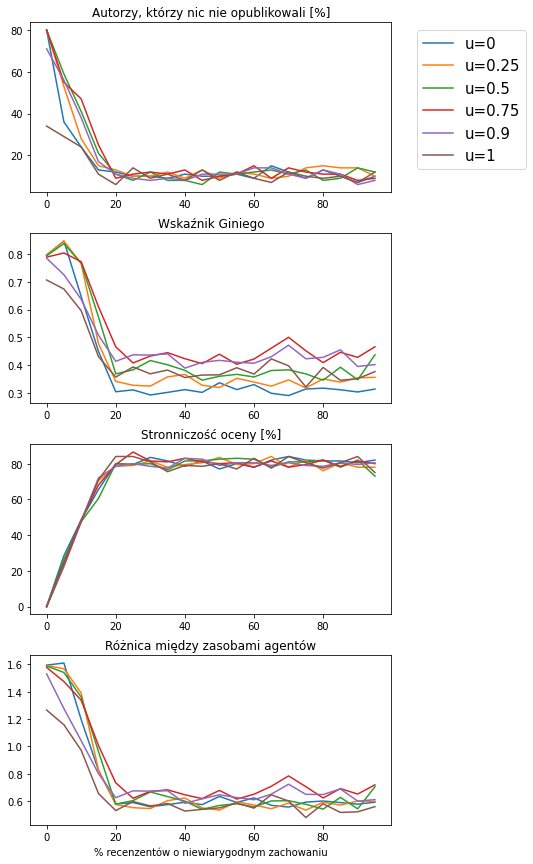

In [94]:
'''
    Wykreślenie parametrów wyznaczonych podczas symulacji w zależności od liczby niewiarygodnych recenzentów
    dla różnych wartości parametru skalującego zasoby po nieudanej publikacji. 
'''
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4,sharex=False,figsize=(6,12))
fig.tight_layout(pad=2.0)
for u in U:
    ax1.plot(randoms,globals()[f"array_unpub_auth{u}"],label = f'u={u}')    
    ax2.plot(randoms,globals()[f"array_gini{u}"])
    ax3.plot(randoms,globals()[f"array_ev_bias{u}"]*100)
    ax4.plot(randoms,globals()[f"array_diff_R{u}"])
    
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',prop={'size': 15})
ax1.set_title('Autorzy, którzy nic nie opublikowali [%]')
ax2.set_title('Wskaźnik Giniego')
ax3.set_title('Stronniczość oceny [%]')
ax4.set_title('Różnica między zasobami agentów')
ax4.set_xlabel("% recenzentów o niewiarygodnym zachowaniu")

plt.savefig("params-randoms-0.pdf",bbox_inches='tight')
plt.show()

In [98]:
#  funkcja przeprowadzająca symulację w celu uzyskania histogramów zasobó agentów
def run_simulation_hist(i,u):

    for ss in range(n_sym):
        s = Simulation(N,N_p,i)        

        for j in range(n_krok): 
            s.function(j+1,u) 
        s.resources(ss,globals()[f"resources{u}"])

100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


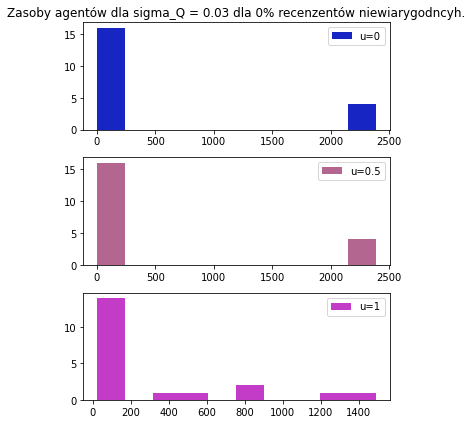

100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


<Figure size 432x288 with 0 Axes>

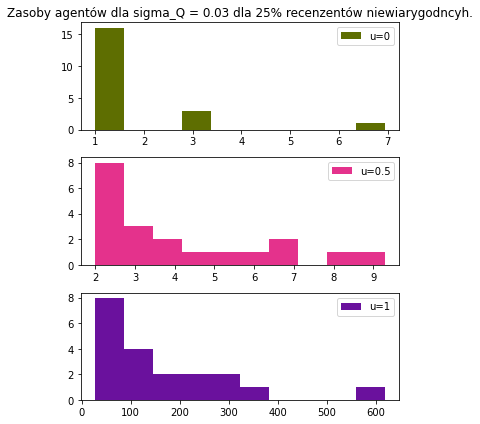

100%|██████████| 3/3 [00:00<00:00,  5.66it/s]


<Figure size 432x288 with 0 Axes>

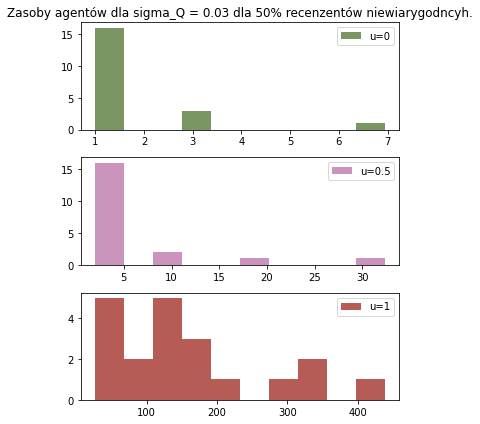

100%|██████████| 3/3 [00:00<00:00,  5.85it/s]


<Figure size 432x288 with 0 Axes>

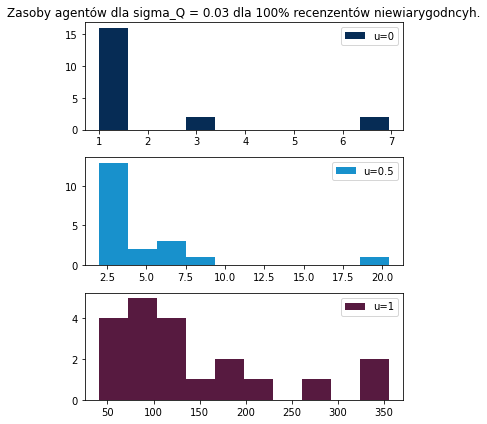

<Figure size 432x288 with 0 Axes>

In [99]:
'''
    Wyznaczenie oraz wykreślenie zasobów agnetów po jednej symulacji dla różnej liczby
    recenzentów niewiarygodnych dla różnych wartości parametru u
'''
number_of_randoms = [0,25,50,100]   
U = [0,0.5,1]

for i in number_of_randoms:
    fig, axs = plt.subplots(3,1,tight_layout=True,figsize=(5,6),sharex=False)
    fig.tight_layout(pad=2.0)
    
    for u in U:
        globals()[f"resources{u}"] = np.zeros(N)
    
    for u in tqdm(U):
        r = np.random.random_sample()
        b = np.random.random_sample()
        g = np.random.random_sample()
        color = (r, g, b)
        run_simulation_hist(i,u)
        axs[U.index(u)].hist(globals()[f"resources{u}"],label= f'u={u}',color=color)
        axs[U.index(u)].legend()
        
    axs[0].set_title(f"Zasoby agentów dla sigma_Q = {Q_sigma} dla {i}% recenzentów niewiarygodncyh.")
    plt.savefig(f"randoms-{Q_sigma}-{i}.pdf")
    plt.show()
    plt.clf()
        